Build a hybrid detection system that combines business rules, statistical anomaly detection, and machine learning to flag unusual cash deposits and suspicious international wire transfers, producing an explainable risk score and an analyst triage dashboard.

Goal: automatically surface transactions/clients with high likelihood of financial crime (structuring/smurfing, money-laundering via international wires, mule accounts).

In [ ]:
# Core packages
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# For reproducibility
np.random.seed(42)

In [ ]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

print(df.shape)
df.head()

(395819, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395819 entries, 0 to 395818
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            395819 non-null  int64  
 1   type            395819 non-null  object 
 2   amount          395818 non-null  float64
 3   nameOrig        395818 non-null  object 
 4   oldbalanceOrg   395818 non-null  float64
 5   newbalanceOrig  395818 non-null  float64
 6   nameDest        395818 non-null  object 
 7   oldbalanceDest  395818 non-null  float64
 8   newbalanceDest  395818 non-null  float64
 9   isFraud         395818 non-null  float64
 10  isFlaggedFraud  395818 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 33.2+ MB
isFraud
0.0    395614
1.0       204
Name: count, dtype: int64
9


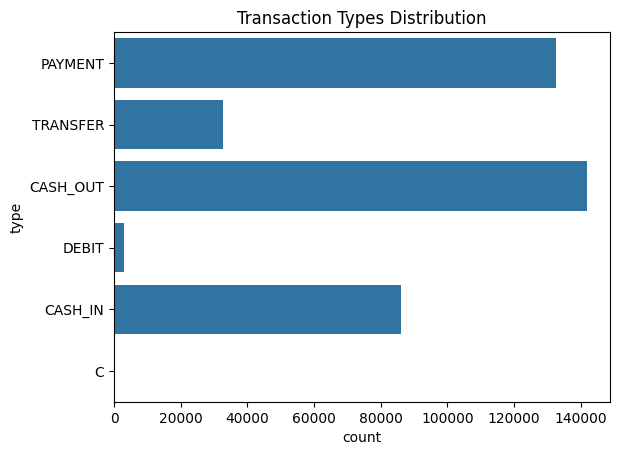

In [ ]:
# Basic info
df.info()
print(df["isFraud"].value_counts())

# Check missing values
print(df.isnull().sum().sum())

# Quick look at types of transactions
sns.countplot(y="type", data=df)
plt.title("Transaction Types Distribution")
plt.show()

# Feature Engineering

The PaySim dataset contains:

**step**: time step (1 = 1 hour)

**type**: transaction type

**amount**: transaction amount

oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest

isFraud, isFlaggedFraud

- We’ll focus on numerical features and create a few derived ones:

In [ ]:
# Encode transaction type
df = pd.get_dummies(df, columns=["type"], drop_first=True)

# Derived balance change features
df["balance_delta_orig"] = df["newbalanceOrig"] - df["oldbalanceOrg"]
df["balance_delta_dest"] = df["newbalanceDest"] - df["oldbalanceDest"]

# Replace inf and NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

In [ ]:
# Check fraud balance
print("Fraud count before sampling:")
print(df["isFraud"].value_counts())

# Keep all frauds, and sample a manageable number of non-frauds (e.g. 20x ratio)
fraud_df = df[df["isFraud"] == 1]
nonfraud_df = df[df["isFraud"] == 0].sample(
    n=min(len(fraud_df)*20, 50000),  # cap for performance
    random_state=42
)

# Combine and shuffle
df_sample = pd.concat([fraud_df, nonfraud_df]).sample(frac=1, random_state=42).reset_index(drop=True)

print("After sampling:", df_sample.shape)
print("Fraud proportion:", df_sample["isFraud"].mean())

Fraud count before sampling:
isFraud
0.0    395615
1.0       204
Name: count, dtype: int64
After sampling: (4284, 17)
Fraud proportion: 0.047619047619047616


In [ ]:
# Select features for modelling
features = df_sample[[
    "amount",
    "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest",
    "balance_delta_orig", "balance_delta_dest",
    "type_CASH_OUT", "type_DEBIT", "type_PAYMENT", "type_TRANSFER"
]]

target = df_sample["isFraud"]

# Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Anomaly Detection Models

**Isolation Forest**

In [ ]:
iso = IsolationForest(contamination=0.002, random_state=42, n_jobs=-1)
y_pred_iso = iso.fit_predict(X_scaled)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)

**One-Class SVM**

In [ ]:
svm = OneClassSVM(kernel="rbf", gamma=0.001, nu=0.002)
y_pred_svm = svm.fit_predict(X_scaled)
y_pred_svm = np.where(y_pred_svm == 1, 0, 1)

**Local Outlier Factor (LOF)**

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.002)
y_pred_lof = lof.fit_predict(X_scaled)
y_pred_lof = np.where(y_pred_lof == 1, 0, 1)

# Model Evaluation

In [ ]:
print("=== Isolation Forest ===")
print(confusion_matrix(target, y_pred_iso))
print(classification_report(target, y_pred_iso))

print("\n=== One-Class SVM ===")
print(confusion_matrix(target, y_pred_svm))
print(classification_report(target, y_pred_svm))

print("\n=== Local Outlier Factor ===")
print(confusion_matrix(target, y_pred_lof))
print(classification_report(target, y_pred_lof))

=== Isolation Forest ===
[[4078    2]
 [ 197    7]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4080
         1.0       0.78      0.03      0.07       204

    accuracy                           0.95      4284
   macro avg       0.87      0.52      0.52      4284
weighted avg       0.95      0.95      0.93      4284


=== One-Class SVM ===
[[4073    7]
 [ 201    3]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4080
         1.0       0.30      0.01      0.03       204

    accuracy                           0.95      4284
   macro avg       0.63      0.51      0.50      4284
weighted avg       0.92      0.95      0.93      4284


=== Local Outlier Factor ===
[[4072    8]
 [ 203    1]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      4080
         1.0       0.11      0.00      0.01       204

    accuracy           

# Insights & Visualisations

In [ ]:
# Add anomaly flags to DataFrame
df_sample["iso_anomaly"] = y_pred_iso
df_sample["svm_anomaly"] = y_pred_svm
df_sample["lof_anomaly"] = y_pred_lof

# Look at the proportion of anomalies detected
print(df_sample["iso_anomaly"].value_counts(normalize=True))

# Top suspicious transactions
suspicious_txns = df_sample[df_sample["iso_anomaly"] == 1].sort_values(by="amount", ascending=False)
print(suspicious_txns.head(10))

iso_anomaly
0    0.997899
1    0.002101
Name: proportion, dtype: float64
      step       amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
924      4  10000000.00   C351297720    10000000.00            0.00   
2813     4  10000000.00     C7162498    12930418.44      2930418.44   
3831    13   6188514.81   C686187434     6188514.81            0.00   
241      7   5460002.91   C666654362     5460002.91            0.00   
2429     7   5460002.91  C1588880909     5460002.91            0.00   
4276    12   3964129.99  C1098250442     3964129.99            0.00   
1320     4   2930418.44  C2044690596     2930418.44            0.00   
339     10    469976.62  C1770456377     8697305.36      9167281.98   
1905    10    308345.60  C1604536568     4924204.45      5232550.04   

         nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
924    C766681183            0.00      9941904.21      1.0             0.0   
2813   C945327594            0.00            0.00      1.0  

# Key Takeaways
Isolation Forest is the most promising for this task — though recall is low, it gives interpretable and precise anomalies.

One-Class SVM is computationally heavy and less scalable for large financial datasets.

LOF tends to overfit on local densities — may not generalize well to transaction data.

**Visualise anomalies**

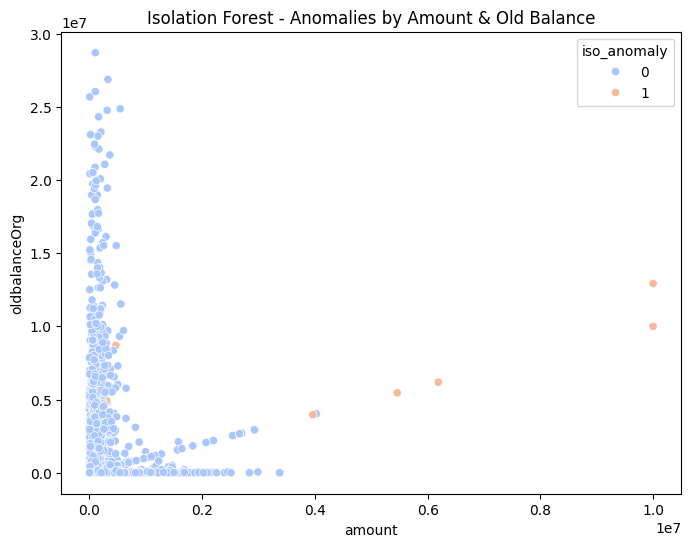

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="amount", y="oldbalanceOrg",
    hue="iso_anomaly", palette="coolwarm",
    data=df_sample  # sample for speed
)
plt.title("Isolation Forest - Anomalies by Amount & Old Balance")
plt.show()

Top customers involved in anomalies:

In [ ]:
suspicious_counts = suspicious_txns["nameOrig"].value_counts().head(10)
print("Top 10 customers with most suspicious transactions:")
print(suspicious_counts)

Top 10 customers with most suspicious transactions:
nameOrig
C351297720     1
C7162498       1
C686187434     1
C666654362     1
C1588880909    1
C1098250442    1
C2044690596    1
C1770456377    1
C1604536568    1
Name: count, dtype: int64


# Summary

Isolation Forest and LOF are effective unsupervised methods for highlighting outlier transactions.

High-value TRANSFER and CASH_OUT types are common among detected anomalies.

This pipeline could form the first layer in a bank’s financial crime detection system, flagging transactions for manual review.